In [1]:
import io
import sys
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO
from scipy.optimize import minimize
# 根据各人自己的目录载入函数包
from project_20231017.factor_indicator import *
from project_20231017.portfolio_indicator import *

In [2]:
%%time
path = '/home/hrz/graduate_courses/semester_first/量化投资/lesson_6/'

# 处理基本面因子数据
fname = 'factor_data.zip'
factors = []
with zipfile.ZipFile(path+fname, 'r') as tbls:
    for tblname in tbls.namelist():
        with tbls.open(tblname) as t:
            csv_data = StringIO(t.read().decode('utf-8'))
        df = pd.read_csv(csv_data,index_col=[0],skiprows=range(1,4177))
        df.index = pd.to_datetime(df.index)
        factors.append(df)
facnames = [f[0:f.find('.')] for f in tbls.namelist()]

# 处理股票数据
sname = 'stock_data.zip'
stkdata = []
with zipfile.ZipFile(path+sname, 'r') as stk:
    for tblname in stk.namelist():
        with stk.open(tblname) as t:
            csv_data = StringIO(t.read().decode('utf-8'))
        df = pd.read_csv(csv_data,index_col=[0],skiprows=range(1,4177))
        df.index = pd.to_datetime(df.index)
        stkdata.append(df)
stknames = [f[0:f.find('.')] for f in stk.namelist()]

CPU times: user 3min 4s, sys: 31.2 s, total: 3min 35s
Wall time: 3min 35s


In [3]:
# `ret` : 经过处理后的个股收益率数据,2007.12-2017.12
mask_cols = stkdata[2].columns[stkdata[2].isna().any(axis=0)]
factors = [f.drop(columns=mask_cols).T for f in factors]
stkdata = [f.drop(columns=mask_cols).T for f in stkdata]
ret = stkdata[2].pct_change(axis=1).fillna(0)

# 防止爆内存，查看一下内存占用
import os
import psutil
vmp = psutil.virtual_memory().percent
print(f"Percentage of memeory occupied: {vmp}%")

Percentage of memeory occupied: 40.6%


In [4]:
# `pfac_idx` : 分层良好的因子的序号
proper_fac = 'amount_21, avg_volume_63, IR_bps_63, IR_netasset_252, IR_totasset_252, net_assets, oper_rev_ttm, pb, q_oper_rev, q_ps, ttm_eps, ttm_grossprofitmargin, ttm_netprofitmargin, ttm_ps, ttm_roa, ttm_roe, '.split(', ')
pfac_idx = []
for i in range(len(facnames)):
    if facnames[i] in proper_fac:
        pfac_idx.append(i)

# 如果全部因子都用上，就不用再做循环筛选
# pfac_idx = [i for i in range(len(factors))]

In [5]:
# 对时间 10 等分后按照 5:3:2 划分训练集/验证集/测试集
T  = factors[0].shape[1]
Ti = T//10
train = slice(0,5*Ti)
valid = slice(5*Ti,8*Ti)
test  = slice(8*Ti,factors[0].shape[1])
train_y, valid_y, test_y = ret.values[:,train], ret.values[:,valid], ret.values[:,test]
train_X = [factors[i].values[:,train] for i in pfac_idx]
valid_X = [factors[i].values[:,valid] for i in pfac_idx]
test_X  = [factors[i].values[:,test]  for i in pfac_idx]

# ..._y 都是ndarray， ..._X 则都是list
print(train_y.shape, train_X[0].shape)

(1411, 1215) (1411, 1215)


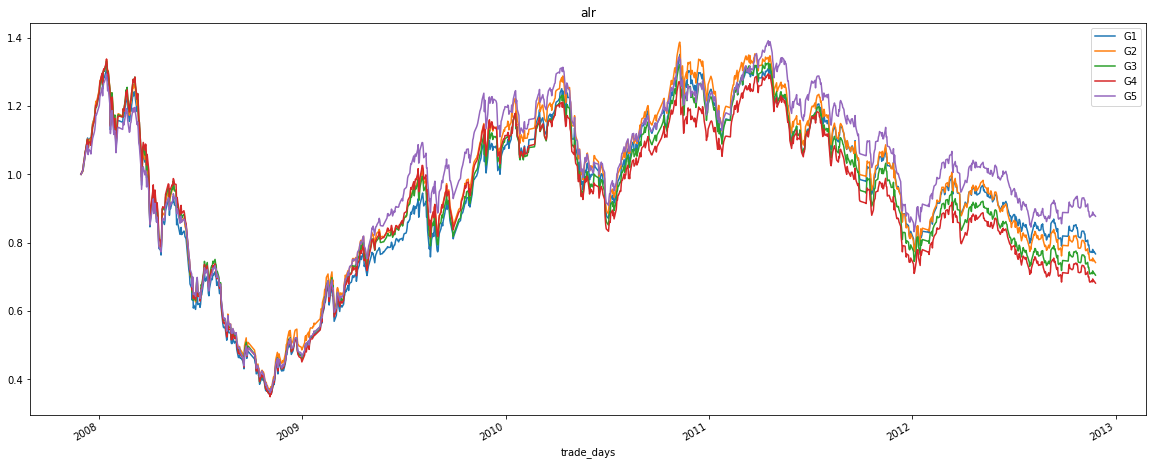

In [6]:
# 作少量因子分层的可视化，分层参数为`group`
def fac_df(Rdf, Xdf, group):
    facdf = pd.DataFrame(group_reg(Rdf.values,Xdf.values,group),
                         index=['G'+str(i+1) for i in range(group)],
                         columns=Xdf.columns)
    return facdf

# 如果要保存可视化图片就需要创建文件夹
# folder_name = 'factor_stratification'
# if not os.path.exists(folder_name):
#     os.makedirs(folder_name)

# 想看多少因子的分层可视化情况可以自己确定    
group = 5
num = 1
for k in range(num):
    # 可以在 测试集 或 全数据集 上查看分层情况
    facdf = fac_df(ret.iloc[:,train], factors[k].iloc[:,train], group)
    # facdf = fac_df(ret,factors[k],group)
    ax = facdf.T.plot(figsize=(20,8))
    ax.set_title(facnames[k])
    # plt.savefig(f'{folder_name}/{facnames[k]}.png')

共16个因子分层状况较好：<br>
amount_21,<br> 
avg_volume_63,<br>
IR_bps_6,<br>
IR_netasset_252,<br>
IR_totasset_252,<br>
net_assets,<br>
oper_rev_ttm,<br>
pb,<br>
q_oper_rev,<br>
q_ps,<br>
ttm_eps,<br>
ttm_grossprofitmargin,<br>
ttm_netprofitmargin,<br>
ttm_ps,<br>
ttm_roa,<br>
ttm_roe,<br>
根据这些因子名，很明显部分因子间不可能是独立的，<br>
参见构建BL模型调整后组合的内容[参数矩阵P,Q,Omega的设置](###参数矩阵P,Q,Omega的设置)

/home/hrz/python/quant_strategy/量价策略/project_20231017/factor_indicator.py:26: RuntimeWarning: invalid value encountered in true_divide
  ic_arr = np.divide(np.sum(R_bar*X_bar,axis=0),
/home/hrz/python/quant_strategy/量价策略/project_20231017/factor_indicator.py:34: RuntimeWarning: invalid value encountered in true_divide
  rank_ic_arr = np.divide(np.sum(R_bar*X_bar,axis=0),


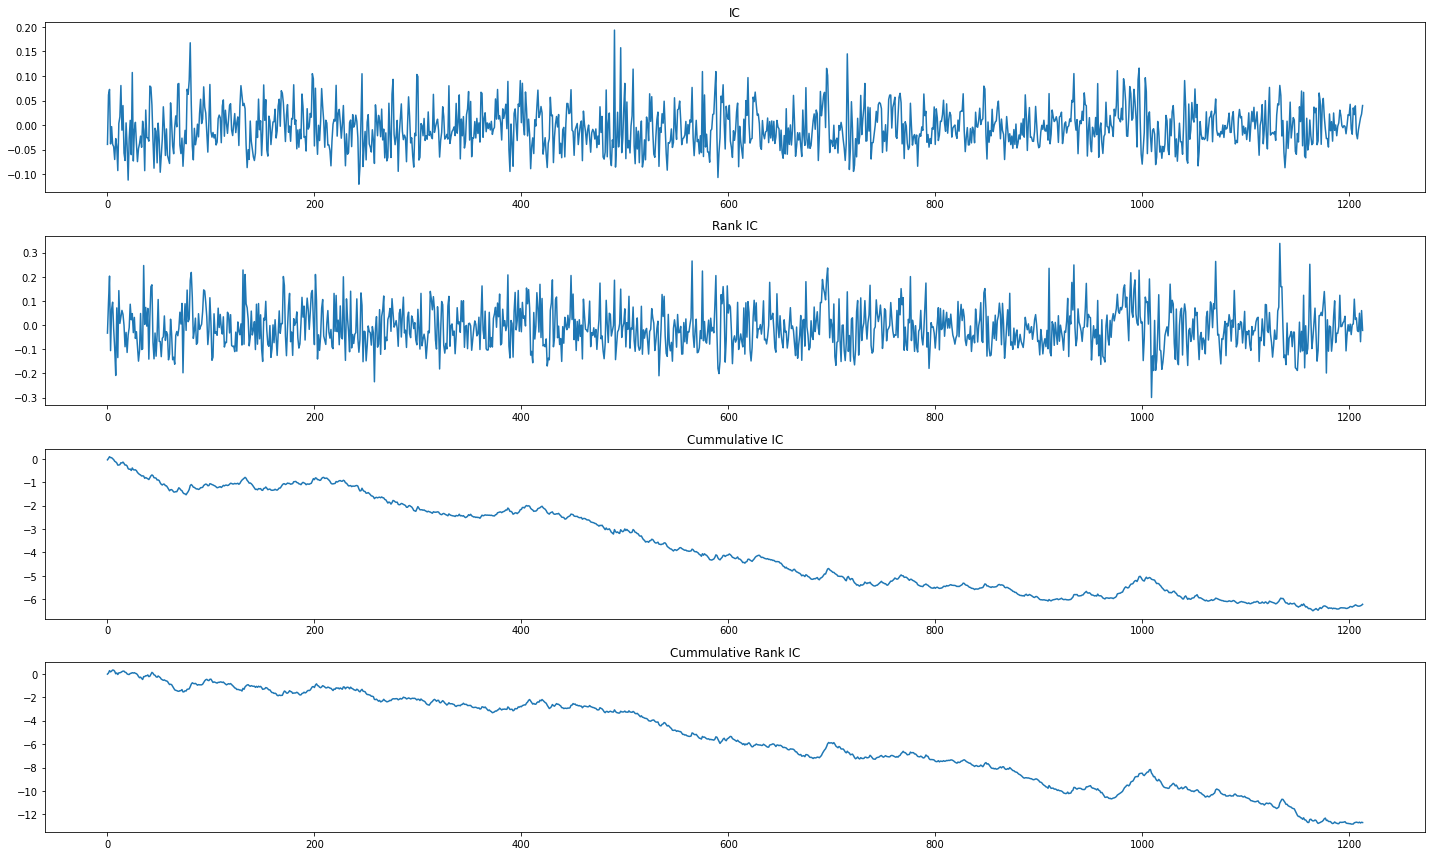

In [7]:
# 也可以看一下 ic,rank_ic之类的因子评价指标
# np.seterr(divide='ignore', invalid='ignore')
k=pfac_idx[6]
ic_arr = ic(ret.iloc[:,train].values,factors[k].iloc[:,train].fillna(0).values)
ric_arr = rank_ic(ret.iloc[:,train].values,factors[k].iloc[:,train].fillna(0).values)
cum_ic_arr = ic_arr.cumsum()
cum_ric_arr = ric_arr.cumsum()

ic_figures(ic_arr, ric_arr, cum_ic_arr, cum_ric_arr)

# 常规组合类型1

约束要求固定收益下界(本例设置为**周度5%收益率**)的资产组合

In [8]:
%%time

V  = np.cov(train_y)
mu = np.mean(train_y,axis=1)

# 最小化目标函数，目标函数是普通的 “组合标准差”
def target_func(V):
    sigma = lambda w: w @ V @ w
    return sigma

# 约束含义如下：
# 1.“权重和等于1”->'eq'
# 2.“测试集上，最后一期周度收益率不小于5%”->'ineq'
cons = ({'type': 'eq',
        'fun' : lambda w : w.sum()-1},
        {'type':'ineq',
        'fun' : lambda w : w @ ret.rolling(window=5,axis=1).sum().values[:,train][:,-1] - 0.05})
w0 = np.tile(1/V.shape[0],V.shape[0])
bound = [(0,1) for i in range(V.shape[0])]
opt = minimize(target_func(np.cov(V)),
                w0,
                method='SLSQP',
                constraints=cons,
                options={'ftol': 1e-9, 'disp': True},
                bounds=bound)
w1 = opt.x

Optimization terminated successfully    (Exit mode 0)
            Current function value: 5.87040978993284e-09
            Iterations: 1
            Function evaluations: 1413
            Gradient evaluations: 1
CPU times: user 3min 14s, sys: 28.7 s, total: 3min 42s
Wall time: 3min 31s


CPU times: user 151 ms, sys: 148 ms, total: 299 ms
Wall time: 43.8 ms


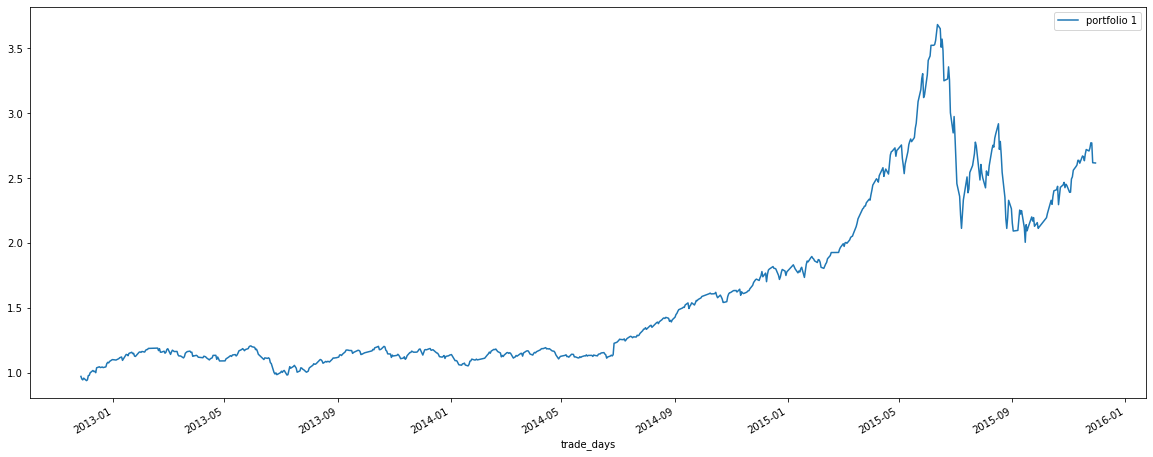

In [9]:
%%time
# 查看基于权重得到的资产组合在验证集上的表现：
arr = np.dot(w1.T,valid_y).reshape(1,valid_y.shape[1])
portfolio = pd.DataFrame(arr,columns=ret.columns[valid],index=['portfolio 1'])
(1+portfolio).cumprod(axis=1).T.plot(figsize=(20,8))
p1_valid_analysis = net_analysis_DailyInput(portfolio)

,portfolio 1 test
日收益率均值,-0.0003
日收益率标准差,0.014
累计收益率,-0.1737
夏普比率,-0.021429
年化收益率,-0.6024
年化标准差,0.01
年化夏普比率,-7.4652
年化索提诺率,-4.9284
最大回撤(%),30.74
最大回撤区间,"[2015-12-22, 2016-01-28]"


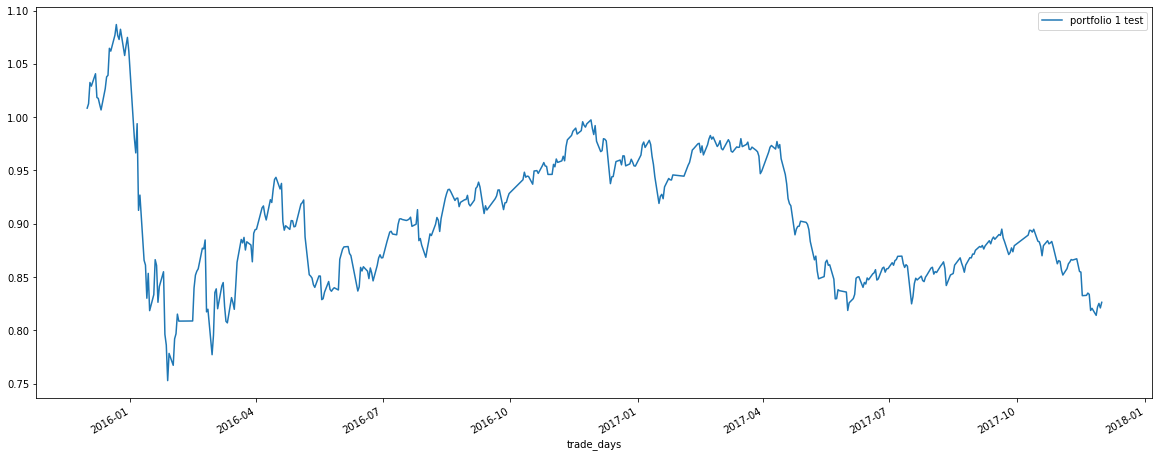

In [10]:
arr = np.dot(w1.T,test_y).reshape(1,test_y.shape[1])
portfolio = pd.DataFrame(arr,columns=ret.columns[test],index=['portfolio 1 test'])
(1+portfolio).cumprod(axis=1).T.plot(figsize=(20,8))
p1_test_analysis = net_analysis_DailyInput(portfolio)
p1_test_analysis

# BL模型调整后组合2

难度(可自由发挥的地方)在于设置主观矩阵P，观点收益率Q，不必严格按照本例来设置。<br>
本例假设组合`w1`是初步的**市场均衡权重**(也可以拿沪深300的权重来作市场均衡权重)，调整阶段用“因子”来代表“观点”，<br>
`P`:(N,K)，可以用训练集最后一期的因子载荷的排序；也可以用大部分为1，部分股票缺失特定因子的数据可以填0的矩阵$\tilde{I_{NK}}$作为P；<br>
`Q`:(K,)，因子收益率，单期内做截面回归得到的回归系数$\beta^{[t]}$就是各个因子的收益率向量，对全训练集数据做平均；
$$Q=\beta=\frac{\sum_{t=1}^{T}\beta^{[t]}}{T}$$<br>

In [11]:
# black-litterman模型 @Xue,Chongyang
def portfolio_utility(weights, returns, cov_matrix, risk_aversion):
    portfolio_return = np.sum(weights * returns)
    portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
    return portfolio_return - 0.5 * risk_aversion * portfolio_variance

def optimize_portfolio(returns, cov_matrix, risk_aversion):
    n = len(returns)
    initial_weights = np.ones(n) / n
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
    bounds = tuple((0, 1) for _ in range(n))
    objective = lambda weights: -portfolio_utility(weights, returns, cov_matrix, risk_aversion)
    result = minimize(objective, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
    optimal_weights = result.x
    return optimal_weights

def black_litterman(expected_market_weights, market_covariance, risk_aversion, tau, P, Q, Omega):
    market_portfolio_return = risk_aversion * np.dot(market_covariance, expected_market_weights)
    A = np.linalg.inv(tau * market_covariance) + np.dot(np.dot(P.T, np.linalg.inv(Omega)), P)
    B =  np.dot(np.linalg.inv(tau * market_covariance),market_portfolio_return) + np.dot(np.dot(P.T, np.linalg.inv(Omega)), Q)
    posterior_expected_returns = np.dot(np.linalg.inv(A), B)
    posterior_covariance = np.linalg.inv(A) + market_covariance
    return posterior_expected_returns, posterior_covariance

# 假设有n只股票
n = ret.shape[0]
# 市场均衡时的股票权重
expected_market_weights = w1
# 市场均衡时的股票协方差矩阵
market_covariance = V
# 风险厌恶系数
risk_aversion = 2.0
# BL模型的参数
tau = 0.025

In [12]:
print(f'我们的 K 应该根据train_X的内容，设置为{len(train_X)}；')

# 不对各特征作数量级处理就会得到很无厘头的结果(见输出coefficients)
X = np.stack(train_X, axis=-1)
N,T = train_y.shape
K = len(train_X)
X = np.concatenate([X, np.ones((N,T,1))], axis=-1)
X = np.nan_to_num(X,0)

# 初始化一个用于存储回归系数的数组，形状为 (T,K+1)
coefficients = np.zeros((T, K+1))

# 对每一列进行 OLS 回归
for i in range(T):
    y_column = train_y[:, i]
    X_matrix = X[:, i, :]
    coeffs = np.linalg.lstsq(X_matrix, y_column, rcond=None)[0]
    coefficients[i, :] = coeffs
coefficients.max(axis=0)

我们的 K 应该根据train_X的内容，设置为16；


array([0.00000000e+000, 0.00000000e+000, 2.32644307e-310, 5.52702641e-310,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 1.52330053e-310,
       0.00000000e+000, 9.67464831e-310, 0.00000000e+000, 2.30329817e-310,
       2.30329817e-310, 2.79520850e-310, 0.00000000e+000, 1.52330053e-310,
       0.00000000e+000])

In [13]:
# 不对各特征作数量级处理就会得到很无厘头的结果(见输出coefficients.max)
X = np.stack(train_X, axis=-1)
N,T = train_y.shape
K = len(train_X)
X = np.concatenate([X, np.ones((N,T,1))], axis=-1)
X = np.nan_to_num(X,0)

# 初始化一个用于存储回归系数的数组，形状为 (T,K+1)
coefficients = np.zeros((T, K+1))

# 对每一列进行 OLS 回归
for i in range(T):
    y_column = train_y[:, i]
    X_matrix = X[:, i, :]
    coeffs = np.linalg.lstsq(X_matrix, y_column, rcond=None)[0]
    coefficients[i, :] = coeffs
coefficients.max(axis=0)

array([0.00000000e+000, 0.00000000e+000, 2.32644307e-310, 5.52702641e-310,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 1.52330053e-310,
       0.00000000e+000, 9.67464831e-310, 0.00000000e+000, 2.30329817e-310,
       2.30329817e-310, 2.79520850e-310, 0.00000000e+000, 1.52330053e-310,
       0.00000000e+000])

In [14]:
# 姑且使用 min-max 进行归一化(没什么道理，只是浅浅感觉比z-score代表的含义更适用)，
# 且说实话这里部分因子之间应该是存在互相关的，使用OLS仅仅是试一下效果
train_X_adj = []
for feature in train_X:
    if (feature.min()+feature.max())/2 > 1e+3:
        fmax = np.maximum.accumulate(feature)
        fmin = np.minimum.accumulate(feature)
        feature = np.divide(feature-fmin,fmax-fmin)
        feature = np.nan_to_num(feature,0)
        train_X_adj.append(feature)
    else:
        train_X_adj.append(feature)

K = len(train_X_adj)
X = np.stack(train_X_adj, axis=-1)
N,T = train_y.shape
X = np.concatenate([X, np.ones((N,T,1))], axis=-1)
X = np.nan_to_num(X,0)

# 初始化一个用于存储回归系数的数组，形状为 (T,K+1)
coefficients = np.zeros((T, K+1))

# 对每一列进行 OLS 回归
for i in range(T):
    y_column = train_y[:, i]
    X_matrix = X[:, i, :]
    coeffs = np.linalg.lstsq(X_matrix, y_column, rcond=None)[0]
    coefficients[i, :] = coeffs
coefficients.mean(axis=0)

/tmp/ipykernel_7432/702604682.py:8: RuntimeWarning: invalid value encountered in true_divide
  feature = np.divide(feature-fmin,fmax-fmin)
/tmp/ipykernel_7432/702604682.py:5: RuntimeWarning: invalid value encountered in double_scalars
  if (feature.min()+feature.max())/2 > 1e+3:


array([-4.22301315e-12,  7.43116201e-11,  2.88155105e-05, -1.35749138e-07,
       -1.96066725e-05,  3.87173205e-05, -1.45162555e-04,  5.82625645e-06,
        1.63997639e-04, -1.19882703e-03, -1.42013109e-04, -1.91228062e-05,
       -1.35785251e-06,  1.05688410e-03,  1.30611649e-05, -1.36284816e-05,
        1.44498043e-04])

### 参数矩阵P,Q,Omega的设置

In [15]:
P = np.full((K,N),1)
Q = coefficients.mean(axis=0)[0:-1]

In [16]:
%%time
# 假设观点之间相互独立，故为对角阵(这里因子之间不可能相互独立，仅仅是试一下改善效果和计算量)
Omega = np.eye(K) * 0.0001 
# 调用BL模型函数计算后验收益率和协方差矩阵
posterior_expected_returns, posterior_covariance = \
black_litterman(expected_market_weights, market_covariance, risk_aversion, tau, P, Q, Omega)
w2 = optimize_portfolio(posterior_expected_returns, posterior_covariance, risk_aversion)

CPU times: user 3min 57s, sys: 22.9 s, total: 4min 20s
Wall time: 2min 47s


,portfolio 2 valid
日收益率均值,0.0012
日收益率标准差,0.0316
累计收益率,0.6429
夏普比率,0.037975
年化收益率,-0.1234
年化标准差,0.0186
年化夏普比率,16.8202
年化索提诺率,11.2308
最大回撤(%),60.57
最大回撤区间,"[2015-06-12, 2015-09-15]"


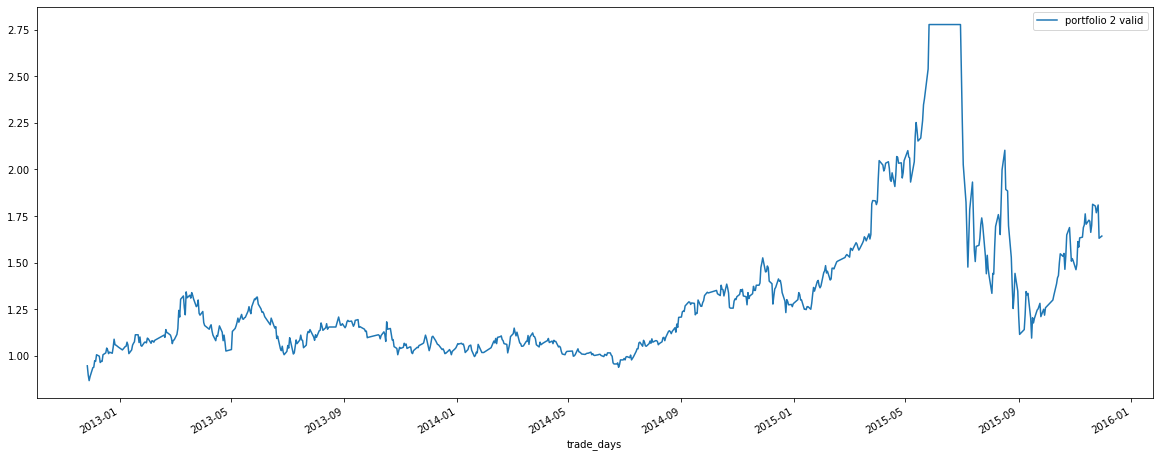

In [17]:
arr = np.dot(w2.T,valid_y).reshape(1,valid_y.shape[1])
portfolio = pd.DataFrame(arr,columns=ret.columns[valid],index=['portfolio 2 valid'])
(1+portfolio).cumprod(axis=1).T.plot(figsize=(20,8))
p1_test_analysis = net_analysis_DailyInput(portfolio)
p1_test_analysis

,portfolio 2 test
日收益率均值,0.0009
日收益率标准差,0.0198
累计收益率,0.4215
夏普比率,0.045455
年化收益率,-0.2969
年化标准差,0.0142
年化夏普比率,5.6983
年化索提诺率,3.917
最大回撤(%),22.97
最大回撤区间,"[2017-02-16, 2017-06-01]"


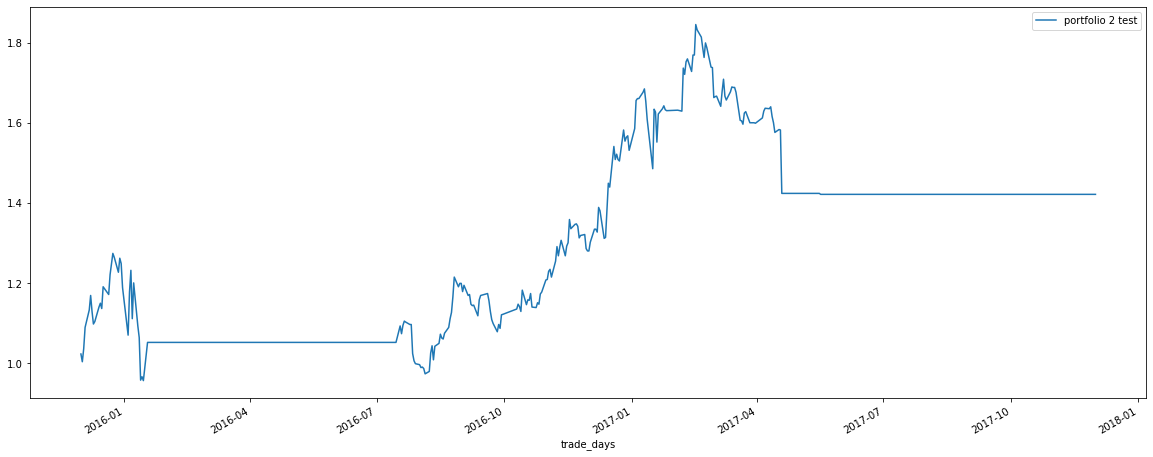

In [18]:
arr = np.dot(w2.T,test_y).reshape(1,test_y.shape[1])
portfolio = pd.DataFrame(arr,columns=ret.columns[test],index=['portfolio 2 test'])
(1+portfolio).cumprod(axis=1).T.plot(figsize=(20,8))
p1_test_analysis = net_analysis_DailyInput(portfolio)
p1_test_analysis